# Floor Plan Analysis & Data Structure Design

This notebook analyzes floor plan data structures and helps design the optimal schema for:
- Houses/Homes
- Floors/Levels
- Rooms
- Spatial relationships
- Floor plan metadata

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Current Database Schema Analysis

Let's analyze the current schema and identify what we have:

In [3]:
# Current schema structure from backend/models/home.py
current_schema = {
    "Home": {
        "id": "UUID",
        "owner_id": "UUID (FK to users)",
        "name": "String(255)",
        "address": "JSON {street, city, province, postal_code, country}",
        "home_type": "Enum (single_family, condo, townhouse, apartment, multi_family, other)",
        "year_built": "Integer",
        "square_footage": "Integer",
        "num_bedrooms": "Integer",
        "num_bathrooms": "Float",
        "num_floors": "Integer (default=1)",
        "digital_twin_completeness": "Float (0.0-1.0)",
        "last_updated_at": "String (ISO timestamp)",
        "extra_data": "JSON",
        "created_at": "DateTime",
        "updated_at": "DateTime"
    },
    "FloorPlan": {
        "id": "UUID",
        "home_id": "UUID (FK)",
        "name": "String(255)",
        "floor_level": "Integer (default=1)",
        "image_url": "String(500)",
        "scale": "String(100) - e.g., '1/4 inch = 1 foot'",
        "is_analyzed": "Boolean",
        "analysis_date": "String (ISO timestamp)",
        "analysis_metadata": "JSON",
        "file_size": "Integer",
        "dimensions": "JSON {width, height} in pixels",
        "created_at": "DateTime",
        "updated_at": "DateTime"
    },
    "Room": {
        "id": "UUID",
        "home_id": "UUID (FK)",
        "name": "String(255)",
        "room_type": "Enum (75+ room types)",
        "floor_level": "Integer (default=1)",
        "length": "Float (feet)",
        "width": "Float (feet)",
        "height": "Float (feet)",
        "area": "Float (sq ft)",
        "condition_score": "Float (0.0-1.0)",
        "style": "String(100)",
        "extra_data": "JSON",
        "created_at": "DateTime",
        "updated_at": "DateTime"
    }
}

# Display as DataFrame
for table_name, fields in current_schema.items():
    print(f"\n{'='*80}")
    print(f"TABLE: {table_name}")
    print(f"{'='*80}")
    df = pd.DataFrame(list(fields.items()), columns=['Field', 'Type'])
    display(df)


TABLE: Home


,Field,Type
0,id,UUID
1,owner_id,UUID (FK to users)
2,name,String(255)
3,address,"JSON {street, city, province, postal_code, cou..."
4,home_type,"Enum (single_family, condo, townhouse, apartme..."
5,year_built,Integer
6,square_footage,Integer
7,num_bedrooms,Integer
8,num_bathrooms,Float
9,num_floors,Integer (default=1)



TABLE: FloorPlan


,Field,Type
0,id,UUID
1,home_id,UUID (FK)
2,name,String(255)
3,floor_level,Integer (default=1)
4,image_url,String(500)
5,scale,"String(100) - e.g., '1/4 inch = 1 foot'"
6,is_analyzed,Boolean
7,analysis_date,String (ISO timestamp)
8,analysis_metadata,JSON
9,file_size,Integer



TABLE: Room


,Field,Type
0,id,UUID
1,home_id,UUID (FK)
2,name,String(255)
3,room_type,Enum (75+ room types)
4,floor_level,Integer (default=1)
5,length,Float (feet)
6,width,Float (feet)
7,height,Float (feet)
8,area,Float (sq ft)
9,condition_score,Float (0.0-1.0)


## 2. Floor Plan Data Structure Requirements

### Key Questions:
1. **Multi-floor handling**: How do we handle homes with multiple floors?
2. **Room-to-Floor relationship**: Should rooms link to floors or directly to homes?
3. **Floor plan metadata**: What additional data do we need for each floor?
4. **Spatial coordinates**: How do we store room positions on floor plans?

In [4]:
# Proposed enhanced schema
proposed_schema = {
    "homes": {
        "core_fields": [
            "id (UUID, PK)",
            "owner_id (UUID, FK)",
            "name (String)",
            "address (JSON)",
            "home_type (Enum)"
        ],
        "physical_characteristics": [
            "year_built (Integer)",
            "total_square_footage (Integer)",
            "num_bedrooms (Integer)",
            "num_bathrooms (Float)",
            "num_floors (Integer)",
            "lot_size (Float) - NEW",
            "garage_spaces (Integer) - NEW"
        ],
        "digital_twin": [
            "digital_twin_completeness (Float)",
            "floor_plans_uploaded (Integer) - NEW",
            "rooms_analyzed (Integer) - NEW",
            "images_uploaded (Integer) - NEW",
            "last_analysis_date (DateTime) - NEW"
        ],
        "metadata": [
            "extra_data (JSON)",
            "created_at (DateTime)",
            "updated_at (DateTime)"
        ]
    },
    "floors": {
        "description": "NEW TABLE - Represents individual floors/levels in a home",
        "fields": [
            "id (UUID, PK)",
            "home_id (UUID, FK)",
            "floor_number (Integer) - 0=basement, 1=main, 2=second, etc.",
            "floor_name (String) - 'Basement', 'Main Floor', 'Second Floor', etc.",
            "total_area (Float) - Total sq ft of this floor",
            "ceiling_height (Float) - Average ceiling height in feet",
            "has_floor_plan (Boolean)",
            "floor_plan_id (UUID, FK to floor_plans) - NULLABLE",
            "extra_data (JSON)",
            "created_at (DateTime)",
            "updated_at (DateTime)"
        ]
    },
    "floor_plans": {
        "core_fields": [
            "id (UUID, PK)",
            "home_id (UUID, FK)",
            "floor_id (UUID, FK) - NEW - Link to specific floor",
            "name (String)",
            "floor_level (Integer) - Keep for backward compatibility"
        ],
        "image_data": [
            "image_url (String)",
            "file_size (Integer)",
            "image_width (Integer) - NEW - Separate from dimensions JSON",
            "image_height (Integer) - NEW",
            "image_format (String) - NEW - jpg, png, pdf, etc."
        ],
        "scale_and_measurements": [
            "scale (String) - e.g., '1/4 inch = 1 foot'",
            "scale_ratio (Float) - NEW - Numeric representation",
            "pixels_per_foot (Float) - NEW - For coordinate conversion",
            "orientation (String) - NEW - north, south, east, west",
            "total_area_detected (Float) - NEW - From AI analysis"
        ],
        "analysis": [
            "is_analyzed (Boolean)",
            "analysis_date (DateTime)",
            "analysis_confidence (Float) - NEW - Overall AI confidence",
            "rooms_detected (Integer) - NEW",
            "analysis_metadata (JSON)"
        ],
        "metadata": [
            "created_at (DateTime)",
            "updated_at (DateTime)"
        ]
    },
    "rooms": {
        "core_fields": [
            "id (UUID, PK)",
            "home_id (UUID, FK)",
            "floor_id (UUID, FK) - NEW - Link to specific floor",
            "floor_plan_id (UUID, FK) - NEW - Which floor plan detected this room",
            "name (String)",
            "room_type (Enum)",
            "floor_level (Integer) - Keep for backward compatibility"
        ],
        "dimensions": [
            "length (Float) - feet",
            "width (Float) - feet",
            "height (Float) - feet",
            "area (Float) - sq ft",
            "volume (Float) - NEW - cubic feet",
            "perimeter (Float) - NEW - feet"
        ],
        "spatial_position": [
            "position_x (Float) - NEW - X coordinate on floor plan",
            "position_y (Float) - NEW - Y coordinate on floor plan",
            "bounding_box (JSON) - NEW - {x1, y1, x2, y2} on floor plan image",
            "polygon_coordinates (JSON) - NEW - Precise room outline"
        ],
        "characteristics": [
            "condition_score (Float)",
            "style (String)",
            "has_images (Boolean) - NEW",
            "image_count (Integer) - NEW",
            "is_analyzed (Boolean) - NEW"
        ],
        "metadata": [
            "extra_data (JSON)",
            "created_at (DateTime)",
            "updated_at (DateTime)"
        ]
    }
}

print("\n" + "="*80)
print("PROPOSED ENHANCED SCHEMA")
print("="*80)

for table_name, sections in proposed_schema.items():
    print(f"\n📊 TABLE: {table_name.upper()}")
    print("-" * 80)
    
    if 'description' in sections:
        print(f"\n🔍 {sections['description']}\n")
    
    for section_name, fields in sections.items():
        if section_name != 'description':
            print(f"\n  {section_name.replace('_', ' ').title()}:")
            for field in fields:
                marker = "🆕" if "NEW" in field else "  "
                print(f"    {marker} {field}")


PROPOSED ENHANCED SCHEMA

📊 TABLE: HOMES
--------------------------------------------------------------------------------

  Core Fields:
       id (UUID, PK)
       owner_id (UUID, FK)
       name (String)
       address (JSON)
       home_type (Enum)

  Physical Characteristics:
       year_built (Integer)
       total_square_footage (Integer)
       num_bedrooms (Integer)
       num_bathrooms (Float)
       num_floors (Integer)
    🆕 lot_size (Float) - NEW
    🆕 garage_spaces (Integer) - NEW

  Digital Twin:
       digital_twin_completeness (Float)
    🆕 floor_plans_uploaded (Integer) - NEW
    🆕 rooms_analyzed (Integer) - NEW
    🆕 images_uploaded (Integer) - NEW
    🆕 last_analysis_date (DateTime) - NEW

  Metadata:
       extra_data (JSON)
       created_at (DateTime)
       updated_at (DateTime)

📊 TABLE: FLOORS
--------------------------------------------------------------------------------

🔍 NEW TABLE - Represents individual floors/levels in a home


  Fields:
       id (UUI

## 3. Floor Type Analysis

Different floor types and how to handle them:


📊 Floor Types Analysis:


,Floor Type,Floor Number,Ceiling Height (ft),Room Count
0,Basement,0,7.5,6
1,Main Floor,1,9.0,6
2,Second Floor,2,8.0,5
3,Third Floor,3,8.0,4
4,Attic,99,6.5,3


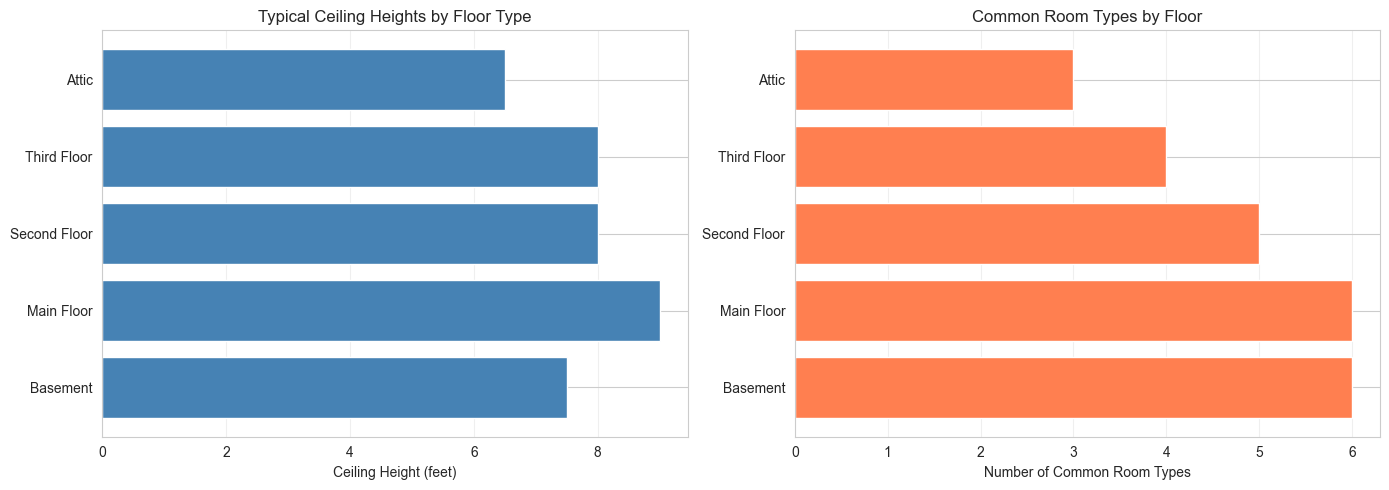

In [5]:
# Common floor types in residential homes
floor_types = {
    "Basement": {
        "floor_number": 0,
        "typical_ceiling_height": 7.5,
        "common_rooms": ["storage", "laundry", "mechanical_room", "rec_room", "bedroom", "bathroom"],
        "characteristics": "Below grade, lower ceilings, utility focus"
    },
    "Main Floor": {
        "floor_number": 1,
        "typical_ceiling_height": 9.0,
        "common_rooms": ["kitchen", "living_room", "dining_room", "foyer", "powder_room", "office"],
        "characteristics": "Primary living space, highest ceilings, main entrance"
    },
    "Second Floor": {
        "floor_number": 2,
        "typical_ceiling_height": 8.0,
        "common_rooms": ["bedroom", "master_bedroom", "bathroom", "laundry", "loft"],
        "characteristics": "Private spaces, bedrooms, bathrooms"
    },
    "Third Floor": {
        "floor_number": 3,
        "typical_ceiling_height": 8.0,
        "common_rooms": ["bedroom", "bathroom", "bonus_room", "office"],
        "characteristics": "Additional bedrooms, bonus spaces"
    },
    "Attic": {
        "floor_number": 99,  # Special designation
        "typical_ceiling_height": 6.5,
        "common_rooms": ["storage", "attic", "bonus_room"],
        "characteristics": "Sloped ceilings, storage, sometimes finished"
    }
}

# Create visualization
floor_df = pd.DataFrame([
    {
        'Floor Type': floor_type,
        'Floor Number': data['floor_number'],
        'Ceiling Height (ft)': data['typical_ceiling_height'],
        'Room Count': len(data['common_rooms'])
    }
    for floor_type, data in floor_types.items()
])

print("\n📊 Floor Types Analysis:")
display(floor_df)

# Visualize ceiling heights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Ceiling heights
ax1.barh(floor_df['Floor Type'], floor_df['Ceiling Height (ft)'], color='steelblue')
ax1.set_xlabel('Ceiling Height (feet)')
ax1.set_title('Typical Ceiling Heights by Floor Type')
ax1.grid(axis='x', alpha=0.3)

# Common room counts
ax2.barh(floor_df['Floor Type'], floor_df['Room Count'], color='coral')
ax2.set_xlabel('Number of Common Room Types')
ax2.set_title('Common Room Types by Floor')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()